In [1]:
import json
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("poster")

colours = sns.color_palette()

%matplotlib inline

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
question_types = {
    1: 'ranking',
    2: 'select5',
    3: 'pointwise_score'
}

json_data=open('../web-selection-form/data/questions.json').read()
question_mapping = json.loads(json_data)

In [3]:
# get the actual questions and answers
print(question_mapping['question1']['answers']['1'])
print(question_mapping['question1']['answers']['10'])

Current admission guidelines for US colleges admissions offices result in the colleges failing to admit many top quality students.
Beyond admissions, colleges should use Data Science as an early warning tool to detect students who need possible assistance.


In [4]:
columns = ([('question1', i) for i in range(1,11)] 
            +[('question1', 'qustion_type'),('question1', 'end_time')]
            +[('question2', i) for i in range(1,11)]
            +[('question2', 'qustion_type'),('question2', 'end_time')]
            +[('question3', i) for i in range(1,11)]
            +[('question3', 'qustion_type'),('question3', 'end_time')]
            +[('feedback', '')]
            +[('start_time', '')]
            +[('end_time', '')])

columns = pd.MultiIndex.from_tuples(columns)

data_df = pd.DataFrame(columns=columns)
data_df.index.name = 'respondent'
data_df

Empty DataFrame
Columns: [(question1, 1), (question1, 2), (question1, 3), (question1, 4), (question1, 5), (question1, 6), (question1, 7), (question1, 8), (question1, 9), (question1, 10), (question1, qustion_type), (question1, end_time), (question2, 1), (question2, 2), (question2, 3), (question2, 4), (question2, 5), (question2, 6), (question2, 7), (question2, 8), (question2, 9), (question2, 10), (question2, qustion_type), (question2, end_time), (question3, 1), (question3, 2), (question3, 3), (question3, 4), (question3, 5), (question3, 6), (question3, 7), (question3, 8), (question3, 9), (question3, 10), (question3, qustion_type), (question3, end_time), (feedback, ), (start_time, ), (end_time, )]
Index: []

[0 rows x 39 columns]

In [5]:
data_path = './../responses/'
# Deal with question 1
    
for index, file in enumerate(os.listdir(data_path)):
    
    if 'second_stage' in file: continue
        
    json_data=open(os.path.join(data_path, file)).read()
    data = json.loads(json_data)

    data_df.set_value(index=index, col=('feedback', ''), value=data['qualitative_feedback'])

    start_time = datetime.datetime.fromtimestamp(data['time_start']/1000.0)
    end_time = datetime.datetime.fromtimestamp(data['time_end']/1000.0)
    
    data_df.set_value(index=index, col=('start_time', ''), value=start_time)
    data_df.set_value(index=index, col=('end_time', ''), value=end_time)

    question_times = [datetime.datetime.fromtimestamp(data['question%i_time'%i]/1000.0) for i in range(1,4)]
    question_times = list(np.sort(question_times + [start_time]))
    
    for question_number in range(1,4):

        question_number_string = 'question%i'%question_number
        question_type = 'question%i_type'%question_number
        question_time = datetime.datetime.fromtimestamp(data['question%i_time'%question_number]/1000.0)
        question_selections = 'question%i_selections'%question_number

        this_q = question_times.index(question_time)
        time_delta = question_times[this_q] - question_times[this_q-1]
        
        data_df.set_value(index=index, col=(question_number_string, 'qustion_type'), value=data[question_type])
        data_df.set_value(index=index, col=(question_number_string, 'end_time'), value=time_delta)

        if data[question_type] == 1: # 'ranking question'

            for i in range(1,11):

                answer = data[question_selections][i-1]
                data_df.set_value(index=index, col=(question_number_string, answer), value=i)

        elif data[question_type] == 2: # 'selecting question'

            for i in range(1,11):

                answer = 10 if i in data[question_selections] else 0
                data_df.set_value(index=index, col=(question_number_string, i), value=answer)

        else: # 'number question'

            answers = []
            for i in range(1,11):

                answers.append(int(data[question_selections][i]))
                
            for i in range(1,11):
                
                data_df.set_value(index=index, col=(question_number_string, i), value=(answers[i-1]/float(np.sum(answers))))

        
data_df = data_df.drop_duplicates()
data_df = data_df.ix[~data_df.index.isin([7,17,28,29])]

In [6]:
data_df

question1                                                         \
                    1          2          3          4          5          6   
respondent                                                                     
0           0.0555556  0.0925926  0.0925926   0.166667   0.037037  0.0740741   
1             0.15625    0.15625    0.15625   0.015625   0.015625   0.015625   
2                  10         10         10          0          0          0   
3                   4          6         10          7          9          5   
4                   3          2          1          8          7         10   
5                   6          4          8          7          5          9   
6                   5          7          4          2         10          9   
8            0.241379   0.103448  0.0344828   0.172414   0.103448  0.0344828   
9            0.132075   0.150943  0.0377358  0.0188679   0.113208   0.132075   
10           0.109091  0.0909091  0.0909091  0.0909091   0.109091  0.0909091   
11          0.0882353   0.205882   0.147059  0.0294118  0.0294118  0.0588235   
12                  6          3          9          5          4         10   
13           0.078125   0.109375    0.09375    0.09375      0.125     0.0625   
14                  6          1          3          7          8          5   
15                 10         10          0          0         10         10   
16                 10          0          0          0         10          0   
18                  0          0          0          0         10         10   
19           0.117647  0.0235294  0.0823529   0.117647  0.0941176   0.117647   
20           0.115385  0.0769231  0.0897436   0.102564   0.102564  0.0641026   
21              0.125   0.111111  0.0972222   0.111111  0.0694444  0.0972222   
22                  7          4          9          1          3          5   
23                  3          1          2         10          6          5   
24                 10         10         10          0          0          0   
25          0.0357143   0.160714      0.125      0.125  0.0892857  0.0357143   
26                 10         10         10          0          0          0   
27                  1          9          5          8          4          3   
30          0.0862069  0.0862069   0.137931  0.0172414   0.137931  0.0689655   
31                  7          3          5          6          8          4   
32           0.106383   0.212766   0.212766  0.0851064  0.0425532  0.0638298   
33                  2          4          5          6          7          8   
34                  2          5          4          7          6          9   
35          0.0555556   0.166667   0.222222  0.0555556  0.0555556   0.111111   
36           0.120482  0.0843373   0.060241   0.060241   0.120482  0.0963855   
37           0.142857   0.128571  0.0714286  0.0571429  0.0857143   0.114286   
38                  0          0          0          0         10         10   
39                  2          4          1          9          8          7   
40                  3          4          5          8          7          2   

                                                        \
                    7          8          9         10   
respondent                                               
0            0.166667    0.12963   0.148148   0.037037   
1             0.15625    0.15625    0.15625   0.015625   
2                   0          0         10         10   
3                   8          3          1          2   
4                   5          4          9          6   
5                  10          3          1          2   
6                   1          8          6          3   
8           0.0344828   0.172414  0.0344828  0.0689655   
9            0.188679  0.0754717   0.132075  0.0188679   
10          0.0909091   0.145455  0.0909091  0.0909091   
11           0.147059  0.0294118   0.205882  0.0588235   

Question 1
<i>Many people feel that USA college admissions are highly skewed toward outdated metrics. Recent research has uncovered metrics that are better able to predict students' future performance in college. However, colleges are reluctant to adopt these new metrics.</i><br/><br/>Imagine that you are in a debate and you are asked to support the argument that USA college admissions should change their admission metrics.


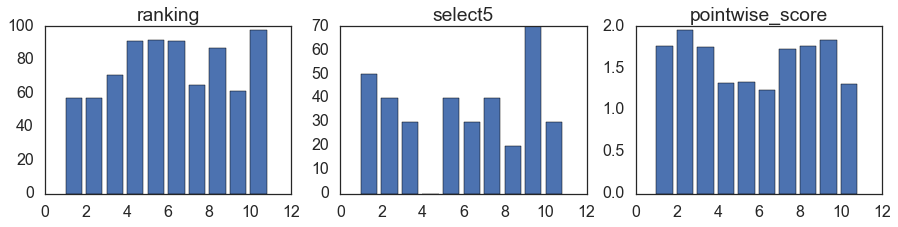

In [70]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
print('Question 1')
question='question1'
print(question_mapping[question]['question_description'])
for i, ax in enumerate(axes):
    
    agg_num = data_df[question][data_df[question]['qustion_type'] == i + 1][[1,2,3,4,5,6,7,8,9,10]].sum()
    
    q_num = agg_num.index
    data = agg_num.values
    ax.bar(q_num, data)
    ax.set_title(question_types[i+1])

Question 2
<i>The 'get to know you' styled interview is becoming a popular trend. However, research shows that humans are surprisingly bad at inferring essential qualities about an applicant's character and thus may make poor judgments about the future success of an applicant.</i><br/><br/> Imagine that you are in a debate and that you are asked to argue in support of the motion above, that the current structure of interviews is not helpful in successful hiring practices.


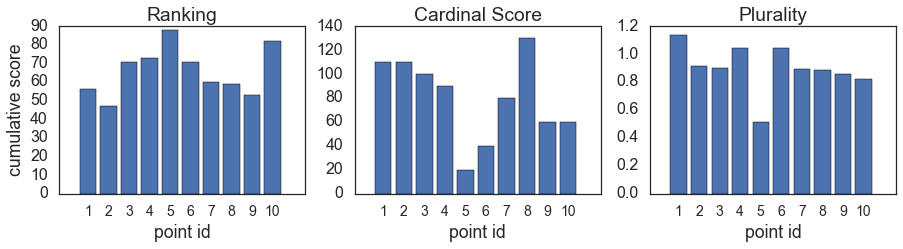

In [75]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
print('Question 2')
question = 'question2'
print(question_mapping[question]['question_description'])
for i, ax in enumerate(axes):
    
    if i == 0:
        q_type = 1
    elif i == 2:
        q_type = 2
    else: 
        q_type = 3
    
    agg_num = data_df[question][data_df[question]['qustion_type'] == i + 1][[1,2,3,4,5,6,7,8,9,10]].sum()
    
    q_num = agg_num.index
    data = agg_num.values
    ax.bar(q_num, data)
    
    if q_type == 1:
        ax.set_title('Ranking')
    elif q_type == 2:
        ax.set_title('Plurality')
    else:
        ax.set_title('Cardinal Score')
        
    if i == 0:
        ax.set_ylabel('cumulative score')
    ax.set_xlabel('point id')
    ax.set_xticks(np.arange(1,11)+0.4)
    ax.set_xticklabels(np.arange(1,11), fontdict={'size':14})


Question 3
<i>The World Health Organization (WHO) has proposed to have video game addiction included in its catalog of mental diseases, but rhetoric stating that video games are addictive and comparing them to drugs is misguided.</i><br/><br/> Imagine that you are in a debate and that you are asked to support the statement that video games should not be classified as addictive.


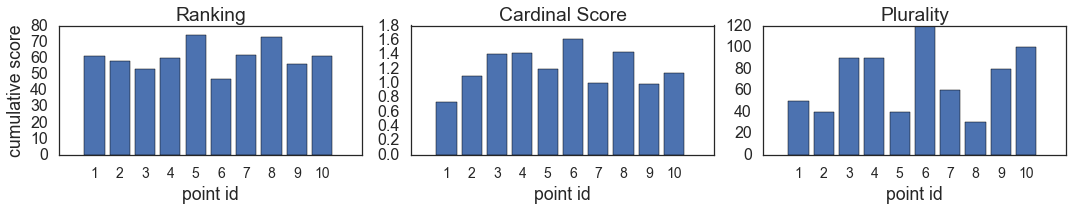

In [76]:
fig, axes = plt.subplots(1,3, figsize=(15,3))
print('Question 3')
question = 'question3'
print(question_mapping[question]['question_description'])
for i, ax in enumerate(axes):
    
    if i == 0:
        q_type = 1
    elif i == 2:
        q_type = 2
    else: 
        q_type = 3
        
    agg_num = data_df[question][data_df[question]['qustion_type'] == q_type][[1,2,3,4,5,6,7,8,9,10]].sum()
    
    agg_num.sort_index(inplace=True)
    q_num = agg_num.index
    data = agg_num.values
    ax.bar(q_num, data)
    
    if q_type == 1:
        ax.set_title('Ranking')
    elif q_type == 2:
        ax.set_title('Plurality')
    else:
        ax.set_title('Cardinal Score')
        
    if i == 0:
        ax.set_ylabel('cumulative score')
    ax.set_xlabel('point id')
    ax.set_xticks(np.arange(1,11)+0.4)
    ax.set_xticklabels(np.arange(1,11), fontdict={'size':14})
fig.tight_layout()

In [73]:
print(question_mapping['question1']['answers']['6'])
print(question_mapping['question1']['answers']['9'])
print(question_mapping['question1']['answers']['8'])
print
print(question_mapping['question2']['answers']['3'])
print(question_mapping['question2']['answers']['5'])
print(question_mapping['question2']['answers']['1'])
print
print(question_mapping['question3']['answers']['6'])
print(question_mapping['question3']['answers']['6'])
print(question_mapping['question3']['answers']['10'])

Improved admissions, resulting in improved graduation rates, will show in world rankings four years after initial implementation.
Currently colleges are not taking advantage of advanced statistical methods that can be used to predict student success.
Admissions officers should be more engaged in the long term goals of the university rather than optimizing for world rankings.

Unstructured, 'get-to-know' interviews are becoming popular in the workspace and in college admissions, yet these form a poor metric for predicting the future job performance of the interviewee.
Students are better at predicting other students' GPA scores when no interview is conducted.
Circumstance may be highly misleading in an interview scenario as an interviewee's demeanor may depend highly on external, hidden circumstances.

The American Journal of Psychiatry has published a study showing that the mental and social heath of the purported video game addicts is no different from individuals who are not addicted

View the qualitative feedback:

In [11]:
for i, f in data_df['feedback'].iteritems():
    
    print(f)
    print('------------------------------------------------------------------------')

Ranking was quite challenging, especially given that several statements were highly similar or conceptually related.
I think it would be helpful to have some very stupid arguments thrown in so that you can have greater variability in your measurement.
Glad to see you taking an interest in social psychology, little sister!
------------------------------------------------------------------------

------------------------------------------------------------------------
ranking is difficult, scoring and/or selecting is easier
------------------------------------------------------------------------
Ticking the 5 most relevant points to support my argument is the easiest form of feedback. Placing the different points in order is the most difficult and requires the most time as you have to read through each point multiple times in order to make comparisons and form the list in the order you want. Ranking the points on a scale of 1-10 is also relatively easy, but may not give the most accurate

In [12]:
data_df['question1'][data_df['question1']['qustion_type'] == 1]

,1,2,3,4,5,6,7,8,9,10,qustion_type,end_time
respondent,,,,,,,,,,,,
3,4,6,10,7,9,5,8,3,1,2,1,0:03:20.055000
4,3,2,1,8,7,10,5,4,9,6,1,0:02:46.078000
5,6,4,8,7,5,9,10,3,1,2,1,0:01:35.948000
6,5,7,4,2,10,9,1,8,6,3,1,0:01:24.361000
12,6,3,9,5,4,10,1,2,8,7,1,0:00:06.229000
14,6,1,3,7,8,5,4,10,2,9,1,0:00:42.892000
22,7,4,9,1,3,5,6,8,10,2,1,0:03:09.368000
23,3,1,2,10,6,5,7,4,8,9,1,0:03:22.487000
27,1,9,5,8,4,3,6,2,7,10,1,0:00:58.677000


In [13]:
ans0 = []
ans1 = []
# j = 0
for question in ['question1','question2','question3']:
    for q_type in [1,3]:
        scores = [[] for i in range(10)]
#         q_type = 1
#         question = 'question3'
        for i,row in data_df[question][data_df[question]['qustion_type'] == q_type].iterrows():

            row = row.ix[0:10]
            row = (row/row.max()) * 10 if q_type == 3 else row
            j = 0
            for _,k in row.iteritems():

                scores[j].append(k)

                j += 1
        
        res = stats.mode(scores, axis=1)
        sorted(np.array([np.mean(scores, axis=1), np.std(scores, axis=1)]).T, key=lambda x: x[1])
        # np.array([np.mean(scores, axis=1), np.std(scores, axis=1)]).T
        ans0.append(np.array([np.mean(scores, axis=1), np.std(scores, axis=1)])[0,:])
        ans1.append(np.array([np.mean(scores, axis=1), np.std(scores, axis=1)])[1,:])
plt.scatter(ans0, ans1)
plt.xlabel('score mean')
plt.ylabel('score std')

NameError: name 'stats' is not defined

In [14]:
np.array([np.mean(scores, axis=1), np.std(scores, axis=1)])

array([[ 4.07142857,  4.07142857,  5.07142857,  6.5       ,  6.57142857,
         6.5       ,  4.64285714,  6.21428571,  4.35714286,  7.        ],
       [ 1.98077495,  2.12011744,  2.84012791,  2.38297533,  1.95354205,
         2.58429322,  2.5803417 ,  3.00424869,  3.41440526,  3.2071349 ]])

In [15]:
def set_regret(profile, S, T):
    '''
    Minimax Regret Set (naive method)
    '''

    if len(T) == 0:
        regret = 0;
        return regret

    

In [16]:
T = set([2,3,7,11])
S = set([1,5])

In [17]:
len(T) == 0

False

In [18]:
profile = [list(np.random.permutation([1,2,3,4,5,6,7,8,9,10])) for i in range(10)]

# first_indices_T = np.array([[i for i,elem in enumerate(x) if x[i] in T][0] + 1 for x in profile])
# first_indices_S = np.array([[i for i,elem in enumerate(x) if x[i] in S][0] + 1 for x in profile])

# regret = np.sum((first_indices_T < first_indices_S)*(1./first_indices_T));
# regret

In [19]:
import itertools
k = 3
permutations1 = itertools.permutations([1,2,3,4,5,6,7,8,9,10], k)

In [34]:
output_regret = np.inf
permutations = None
for S in permutations1:
    
    max_reg = 0
    permutation = None
    
    permutations2 = itertools.permutations([1,2,3,4,5,6,7,8,9,10], k)
    for T in permutations2:
        
        first_indices_T = np.array([[i for i,elem in enumerate(x) if x[i] in T][0] + 1 for x in profile])
        first_indices_S = np.array([[i for i,elem in enumerate(x) if x[i] in S][0] + 1 for x in profile])

        regret = np.sum((first_indices_T < first_indices_S)*(1./first_indices_T));
        
        if regret > max_reg:
            
            max_reg = regret
            
    if max_reg < output_regret:

        output_regret = max_reg
        permutations = S

NameError: name 'profile' is not defined

In [20]:
output_regret

NameError: name 'output_regret' is not defined

In [21]:
permutations

NameError: name 'permutations' is not defined

In [22]:
# question_rank = data_df['question1'][data_df['question1']['qustion_type'] == 1]
# data_df[['question1', 'question2' , 'question3']][data_df[['question1', 'question2' , 'question3'], 'qustion_type'] == 1]
q_type = 1
question_rank = [data_df['question1'][data_df['question1']['qustion_type'] == q_type],
                data_df['question2'][data_df['question2']['qustion_type'] == q_type],
                data_df['question3'][data_df['question3']['qustion_type'] == q_type]]

q_type = 2
question_select = [data_df['question1'][data_df['question1']['qustion_type'] == q_type],
                data_df['question2'][data_df['question2']['qustion_type'] == q_type],
                data_df['question3'][data_df['question3']['qustion_type'] == q_type]]

q_type = 3
question_number = [data_df['question1'][data_df['question1']['qustion_type'] == q_type],
                data_df['question2'][data_df['question2']['qustion_type'] == q_type],
                data_df['question3'][data_df['question3']['qustion_type'] == q_type]]

In [23]:
rank = []
select = []
number = []
rank_std = []
select_std = []
number_std = []

for df in question_rank:
    
    acceptable_times = df[((df.end_time < datetime.timedelta(minutes=20)) & (df.end_time > datetime.timedelta(minutes=0)))]
    
    times = []
    for i, t in acceptable_times.end_time.iteritems():
        
        times.append(t.seconds)
    
    rank.append(times)
    
for df in question_select:
    
    acceptable_times = df[((df.end_time < datetime.timedelta(minutes=20)) & (df.end_time > datetime.timedelta(minutes=0)))]
    
    times = []
    for i, t in acceptable_times.end_time.iteritems():
        
        times.append(t.seconds)
    
    select.append(times)
    
for df in question_number:
    
    acceptable_times = df[((df.end_time < datetime.timedelta(minutes=20)) & (df.end_time > datetime.timedelta(minutes=0)))]
    
    times = []
    for i, t in acceptable_times.end_time.iteritems():
        
        times.append(t.seconds)
    
    number.append(times)

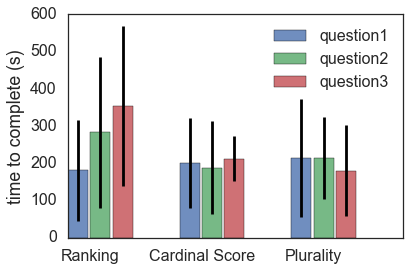

In [49]:
# indexes = np.array([1,1.2,1.4])
indexes = np.array([1,2,3])
answers = np.array([[np.mean(r) for r in rank], [np.mean(r) for r in number], [np.mean(r) for r in select]])
std = np.array([[np.std(r) for r in rank], [np.std(r) for r in select], [np.std(r) for r in number]])

plt.bar(indexes, answers[0,:], yerr=std[0,:], width=0.18, color=[colours[0], colours[0], colours[0]], label='question1', ecolor='black', alpha=0.8)
plt.bar(indexes+0.2, answers[1,:], yerr=std[1,:], width=0.18, color=[colours[1], colours[1], colours[1]], label='question2', ecolor='black', alpha=0.8)
plt.bar(indexes+0.4, answers[2,:], yerr=std[2,:], width=0.18, color=[colours[2], colours[2], colours[2]], label='question3', ecolor='black', alpha=0.8)
plt.ylabel('time to complete (s)')

plt.legend(loc='best')
plt.xticks([1.2,2.2,3.2], ['Ranking', 'Cardinal Score', 'Plurality'])

plt.show()

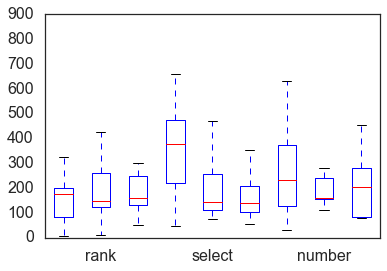

In [25]:
plt.boxplot(rank + select + number)

plt.xticks([2,5,8], ['rank', 'select', 'number'])
plt.show()

In [26]:
question_times = []
type_times = []
types = []
times = []

for index, row in data_df.iterrows():
    
    q1_time = row.question1.end_time.seconds
    q2_time = row.question2.end_time.seconds
    q3_time = row.question3.end_time.seconds
    
#     if q1_time < 60*20 and q2_time < 60*20 and q2_time < 60*20:
        
    if q1_time > 0 and q2_time > 0 and q2_time > 0:
        types_ = [0,0,0]    
        types_[row.question1.qustion_type - 1] = row.question1.end_time.seconds
        types_[row.question2.qustion_type - 1] = row.question2.end_time.seconds
        types_[row.question3.qustion_type - 1] = row.question3.end_time.seconds

        question_times.append(np.argsort([q1_time, q2_time, q3_time]))
        type_times.append(np.argsort(types_))

        times.append([q1_time, q2_time, q3_time])
        types.append([row.question1.qustion_type, row.question2.qustion_type, row.question3.qustion_type])

question_times = np.array(question_times)
type_times = np.array(type_times)

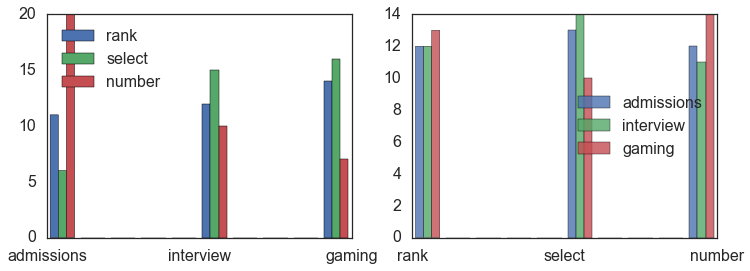

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

ax1.hist(question_times, label=['rank', 'select' , 'number'])
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(['Topic1', 'Topic2', 'Topic3'])
ax1.legend(loc='best')

ax2.hist(type_times, label=['admissions', 'interview' , 'gaming'], alpha=0.8)
ax2.set_xticks([0,1,2])
ax2.set_xticklabels(['Ranking', 'select', 'number'])
ax2.legend(loc='right')

plt.show()

In [60]:
for q in range(1,4):
    
    df = data_df['question{}'.format(q)][data_df['question{}'.format(q)].qustion_type == 2][[1,2,3,4,5,6,7,8,9,10]].sum()
    df.sort_values(inplace=True)
    print(df)
    selections = list(df.index[6:])
    print('Question{}, Type: Plurality'.format(q))
    print(selections)
    
    for i in selections:
        print('"' +question_mapping['question{}'.format(q)]['answers']['{}'.format(i)] + '",')
        
    print

4      0.0
8     20.0
3     30.0
6     30.0
10    30.0
2     40.0
5     40.0
7     40.0
1     50.0
9     70.0
dtype: float64
Question1, Type: Plurality
[5, 7, 1, 9]
"Schools should be unconcerned about brief fluctuations in college ranking scores (caused by different admissions criteria), if it results in a stronger student body.",
"There is currently an inherent disconnect between admissions offices and graduation rates (e.g. there is no direct feedback from graduation to the admissions decisions that were made four years prior).",
"Current admission guidelines for US colleges admissions offices result in the colleges failing to admit many top quality students.",
"Currently colleges are not taking advantage of advanced statistical methods that can be used to predict student success.",

5      20.0
6      40.0
9      60.0
10     60.0
7      80.0
4      90.0
3     100.0
1     110.0
2     110.0
8     130.0
dtype: float64
Question2, Type: Plurality
[3, 1, 2, 8]
"Unstructured, 'get-to-know

In [29]:
qualitative_feedback = np.array([
    [-1, 0, 0],
    [-1, 1, 1],
    [-1, 1, 0],
    [ 0, 0, 1],
    [ 0, 1, 0],
    [ 0, 1,-1],
    [-1, 0, 1],
    [ 0, 1,-1],
    [ 1, 0, 0],
    [-1, 1, 0],
    [ 1, 1, 0],
    [-1, 1, 1],
    [-1, 0, 1],
    [ 1, 1,-1],
    [ 1, 0, 0],
    [ 0, 1, 0],
    [-1, 0, 0]
])

dislike = []
neutral = []
like    = []

for doc in qualitative_feedback:
    
    for i, rating in enumerate(doc):
        
        if rating == -1:
            dislike.append(i+1)
        elif rating == 0:
             neutral.append(i+1)
        else:
             like.append(i+1)

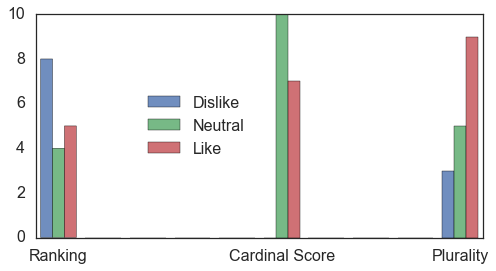

In [46]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.hist([dislike,like,neutral] , label=['Dislike', 'Neutral', 'Like'], color=[colours[0], colours[1], colours[2]], alpha=0.8)

# ax.set_title('Qualitative Feedback', fontdict={'size': 22})
ax.set_xticks([1.1,2.1,2.9])
ax.set_xticklabels(['Ranking', 'Cardinal Score', 'Plurality'], fontdict={'size': 16})
ax.legend(loc='center right', bbox_to_anchor=(0.5, 0.5), fontsize=16)
plt.show()

In [31]:
data_df

question1                                                         \
                    1          2          3          4          5          6   
respondent                                                                     
0           0.0555556  0.0925926  0.0925926   0.166667   0.037037  0.0740741   
1             0.15625    0.15625    0.15625   0.015625   0.015625   0.015625   
2                  10         10         10          0          0          0   
3                   4          6         10          7          9          5   
4                   3          2          1          8          7         10   
5                   6          4          8          7          5          9   
6                   5          7          4          2         10          9   
8            0.241379   0.103448  0.0344828   0.172414   0.103448  0.0344828   
9            0.132075   0.150943  0.0377358  0.0188679   0.113208   0.132075   
10           0.109091  0.0909091  0.0909091  0.0909091   0.109091  0.0909091   
11          0.0882353   0.205882   0.147059  0.0294118  0.0294118  0.0588235   
12                  6          3          9          5          4         10   
13           0.078125   0.109375    0.09375    0.09375      0.125     0.0625   
14                  6          1          3          7          8          5   
15                 10         10          0          0         10         10   
16                 10          0          0          0         10          0   
18                  0          0          0          0         10         10   
19           0.117647  0.0235294  0.0823529   0.117647  0.0941176   0.117647   
20           0.115385  0.0769231  0.0897436   0.102564   0.102564  0.0641026   
21              0.125   0.111111  0.0972222   0.111111  0.0694444  0.0972222   
22                  7          4          9          1          3          5   
23                  3          1          2         10          6          5   
24                 10         10         10          0          0          0   
25          0.0357143   0.160714      0.125      0.125  0.0892857  0.0357143   
26                 10         10         10          0          0          0   
27                  1          9          5          8          4          3   
30          0.0862069  0.0862069   0.137931  0.0172414   0.137931  0.0689655   
31                  7          3          5          6          8          4   
32           0.106383   0.212766   0.212766  0.0851064  0.0425532  0.0638298   
33                  2          4          5          6          7          8   
34                  2          5          4          7          6          9   
35          0.0555556   0.166667   0.222222  0.0555556  0.0555556   0.111111   
36           0.120482  0.0843373   0.060241   0.060241   0.120482  0.0963855   
37           0.142857   0.128571  0.0714286  0.0571429  0.0857143   0.114286   
38                  0          0          0          0         10         10   
39                  2          4          1          9          8          7   
40                  3          4          5          8          7          2   

                                                        \
                    7          8          9         10   
respondent                                               
0            0.166667    0.12963   0.148148   0.037037   
1             0.15625    0.15625    0.15625   0.015625   
2                   0          0         10         10   
3                   8          3          1          2   
4                   5          4          9          6   
5                  10          3          1          2   
6                   1          8          6          3   
8           0.0344828   0.172414  0.0344828  0.0689655   
9            0.188679  0.0754717   0.132075  0.0188679   
10          0.0909091   0.145455  0.0909091  0.0909091   
11           0.147059  0.0294118   0.205882  0.0588235   

# Find the combination of choices most frequently in the top 4:

(14, 12)
(7, 12)
(16, 12)
(12, 12)
(16, 12)
(9, 12)
(11, 12)
(14, 12)
(12, 12)


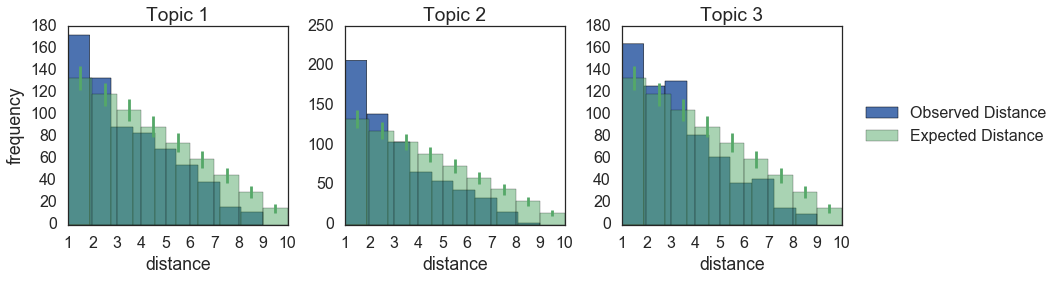

In [50]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
for k, (ax, question) in enumerate(zip(axes, ['question1','question2','question3'])):
    
    res = dict()
    dist = []

#     question = 'question1'

    for ix, group in data_df[question].groupby('qustion_type'):
        print(group.shape)
        gp = group[[1,2,3,4,5,6,7,8,9,10]]

        for i, row in gp.iterrows():
#             print(row.sort_values())
            for window in np.concatenate([np.arange(0,3), np.arange(5,8)]):

                top3 = row.sort_values().index[window:window+3]
#                 print(top3)
                for perm in itertools.combinations(top3, 2):

                    if (tuple(perm) in res):
                        res[tuple(perm)] += 1
                    elif tuple([perm[1], perm[0]]) in res:
                        res[tuple([perm[1], perm[0]])] += 1
                    else:
                        res[tuple(perm)] = 1

                    dist.append(np.abs(perm[0] - perm[1]))
                    
    ax.hist(dist, bins=9, label='Observed Distance')
    ax.set_title('Topic {}'.format(k+1))
    ax.set_xlabel('distance')
    if k == 0:
        ax.set_ylabel('frequency')
        
    ax.bar(np.arange(1,10),means, yerr=stds, color=colours[1], alpha=0.5, width=1, label='Expected Distance')
    
ax.legend(loc='center right', bbox_to_anchor=(2, 0.5), fontsize=16)

fig.tight_layout()
plt.show()

In [37]:
means = np.array(counts).mean(axis=0)

NameError: name 'counts' is not defined

In [33]:
result = []
for i in range(10000):
    
    row = np.random.choice(np.arange(1,11), size=10)
    res = dict()
    dist = []

    for row in [np.random.choice(np.arange(1,11), size=10, replace=False) for i in range(37)]:
        for window in np.concatenate([np.arange(0,3), np.arange(5,8)]):

            top3 = row[window:window+3]
        #     print(top3)

            for perm in itertools.combinations(top3, 2):

                if (tuple(perm) in res):
                    res[tuple(perm)] += 1
                elif tuple([perm[1], perm[0]]) in res:
                    res[tuple([perm[1], perm[0]])] += 1
                else:
                    res[tuple(perm)] = 1
                dist.append(np.abs(perm[0] - perm[1]))

    result.append(dist)
# plt.hist(dist, bins=8)
# plt.xlim([0,9])
# # plt.ylim([0,9])

In [34]:
result[0]

[6,
 1,
 7,
 7,
 2,
 5,
 5,
 2,
 7,
 3,
 7,
 4,
 4,
 1,
 3,
 3,
 5,
 2,
 1,
 6,
 5,
 5,
 1,
 4,
 4,
 1,
 3,
 1,
 5,
 6,
 6,
 1,
 7,
 7,
 1,
 6,
 4,
 3,
 1,
 1,
 4,
 5,
 5,
 4,
 1,
 4,
 6,
 2,
 2,
 1,
 3,
 3,
 7,
 4,
 1,
 4,
 5,
 5,
 2,
 7,
 7,
 3,
 4,
 3,
 5,
 8,
 8,
 1,
 7,
 7,
 4,
 3,
 4,
 3,
 1,
 1,
 1,
 2,
 2,
 3,
 1,
 1,
 7,
 6,
 6,
 5,
 1,
 1,
 8,
 7,
 1,
 6,
 5,
 5,
 2,
 3,
 3,
 4,
 1,
 2,
 3,
 5,
 5,
 1,
 4,
 4,
 1,
 3,
 8,
 3,
 5,
 5,
 2,
 3,
 3,
 4,
 1,
 4,
 1,
 3,
 3,
 1,
 2,
 2,
 7,
 5,
 2,
 3,
 5,
 5,
 4,
 1,
 1,
 4,
 3,
 8,
 9,
 1,
 1,
 7,
 8,
 8,
 4,
 4,
 1,
 8,
 7,
 7,
 5,
 2,
 2,
 3,
 1,
 5,
 1,
 4,
 4,
 3,
 1,
 1,
 4,
 5,
 7,
 4,
 3,
 3,
 5,
 2,
 2,
 1,
 3,
 2,
 5,
 7,
 7,
 4,
 3,
 3,
 8,
 5,
 1,
 3,
 4,
 4,
 4,
 8,
 8,
 6,
 2,
 2,
 6,
 8,
 8,
 6,
 2,
 2,
 5,
 3,
 8,
 4,
 4,
 4,
 2,
 2,
 2,
 1,
 3,
 3,
 4,
 1,
 1,
 3,
 2,
 2,
 6,
 8,
 4,
 6,
 2,
 2,
 2,
 4,
 4,
 3,
 1,
 2,
 9,
 7,
 7,
 6,
 1,
 1,
 3,
 2,
 7,
 6,
 1,
 1,
 1,
 2,
 2,
 7,
 9,
 2,
 1,
 1,
 1,
 3,
 2,
 2,


In [38]:
# for i in result:
import collections
counts = []
for i in result:
    counts.append([c for i,c in collections.Counter(i).iteritems()])

In [39]:
means = np.array(counts).mean(axis=0)
stds = np.array(counts).std(axis=0)

In [ ]:
plt.hist(result)

([array([ 128.,  128.,  101.,   92.,    0.,   64.,   68.,   34.,   34.,   17.]),
  array([ 146.,  103.,  100.,  102.,    0.,   88.,   58.,   41.,   15.,   13.]),
  array([ 134.,  125.,  104.,   87.,    0.,   76.,   60.,   41.,   26.,   13.]),
  array([ 126.,  101.,  111.,   81.,    0.,   83.,   72.,   38.,   38.,   16.]),
  array([ 161.,  109.,   96.,   64.,    0.,   77.,   57.,   37.,   42.,   23.]),
  array([ 136.,  117.,   96.,  104.,    0.,   67.,   55.,   51.,   28.,   12.]),
  array([ 146.,  126.,  104.,   83.,    0.,   63.,   59.,   41.,   30.,   14.]),
  array([ 137.,  118.,  104.,   79.,    0.,   72.,   64.,   43.,   37.,   12.]),
  array([ 129.,  113.,  105.,   82.,    0.,   85.,   64.,   36.,   35.,   17.]),
  array([ 116.,  122.,   93.,   96.,    0.,   81.,   67.,   48.,   29.,   14.]),
  array([ 141.,   84.,  110.,   97.,    0.,   80.,   63.,   46.,   26.,   19.]),
  array([ 139.,   96.,  105.,   95.,    0.,   75.,   53.,   49.,   36.,   18.]),
  array([ 138.,   96.,  105.

In [ ]:
[[k, res[k]] for k in sorted(res, key=lambda x: res[x])]

In [ ]:
[3, 4, 10, 6]

In [ ]:
plt.hist(dist)
plt.show()